# Python for Data Wrangling

## Why Python?

Created as general-purpose programming language: large user base from diverse disciplines
Strong libraries, machine learning in particular


## Pandas

Pandas is a Python library for working with datasets. It supports data frame-like data structure like in R. 


In [1]:
# load the pandas library
import pandas as pd
# we also load numpy for array computation for convenience
import numpy as np
mimic_path = "../mimic-iv-1.0/"

### Loading data

Let's load `icustays.csv.gz` file as a pandas data frame. We need to predetermine the columnes with date-time values.

In [2]:
icustays_df = pd.read_csv(mimic_path + "/icu/icustays.csv.gz", parse_dates=["intime", "outtime"])
print(icustays_df)

       subject_id   hadm_id   stay_id  \
0        17867402  24528534  31793211   
1        14435996  28960964  31983544   
2        17609946  27385897  33183475   
3        18966770  23483021  34131444   
4        12776735  20817525  34547665   
...           ...       ...       ...   
76535    15368898  27299174  39990887   
76536    15721773  28911582  39991872   
76537    12275003  22562812  39992247   
76538    17577670  24221219  39993265   
76539    17840864  22695803  39999810   

                                         first_careunit  \
0                                   Trauma SICU (TSICU)   
1                                   Trauma SICU (TSICU)   
2                                   Trauma SICU (TSICU)   
3                                   Trauma SICU (TSICU)   
4                                        Neuro Stepdown   
...                                                 ...   
76535                               Trauma SICU (TSICU)   
76536                Medical Intens

We can check the class of `icustays_df`:

In [3]:
icustays_df.__class__

pandas.core.frame.DataFrame

Now `admissions.csv.gz`:

In [4]:
admissions_df = pd.read_csv(mimic_path + "/core/admissions.csv.gz",
                           parse_dates = ["admittime", "dischtime", "deathtime", "edregtime", "edouttime"])
print(admissions_df)

        subject_id   hadm_id           admittime           dischtime  \
0         14679932  21038362 2139-09-26 14:16:00 2139-09-28 11:30:00   
1         15585972  24941086 2123-10-07 23:56:00 2123-10-12 11:22:00   
2         11989120  21965160 2147-01-14 09:00:00 2147-01-17 14:25:00   
3         17817079  24709883 2165-12-27 17:33:00 2165-12-31 21:18:00   
4         15078341  23272159 2122-08-28 08:48:00 2122-08-30 12:32:00   
...            ...       ...                 ...                 ...   
523735    17892964  20786062 2180-09-17 00:00:00 2180-09-18 13:37:00   
523736    17137572  20943099 2147-08-01 17:41:00 2147-08-02 17:30:00   
523737    19389857  23176714 2189-03-01 00:58:00 2189-03-02 15:22:00   
523738    12298845  22347500 2138-05-31 00:00:00 2138-06-04 16:50:00   
523739    11211939  24981356 2147-08-02 15:49:00 2147-08-05 16:30:00   

       deathtime               admission_type      admission_location  \
0            NaT                     ELECTIVE                 

And `patients.csv.gz`:

In [5]:
patients_df = pd.read_csv(mimic_path + "/core/patients.csv.gz")
print(patients_df)

        subject_id gender  anchor_age  anchor_year anchor_year_group  dod
0         10000048      F          23         2126       2008 - 2010  NaN
1         10002723      F           0         2128       2017 - 2019  NaN
2         10003939      M           0         2184       2008 - 2010  NaN
3         10004222      M           0         2161       2014 - 2016  NaN
4         10005325      F           0         2154       2011 - 2013  NaN
...            ...    ...         ...          ...               ...  ...
382273    19998203      M          29         2132       2011 - 2013  NaN
382274    19998350      M          52         2127       2011 - 2013  NaN
382275    19999068      M          63         2161       2011 - 2013  NaN
382276    19999270      M          33         2184       2014 - 2016  NaN
382277    19999298      M          20         2177       2011 - 2013  NaN

[382278 rows x 6 columns]


For `chartevents_filtered_itemid.csv.gz`, we learn how to read in only selected columns.

In [6]:
from timeit import default_timer as timer

In [7]:
start = timer()
chartevents_df = pd.read_csv(
    mimic_path + "/icu/chartevents_filtered_itemid.csv.gz",
    usecols = ["stay_id", "itemid", "charttime", "valuenum"],
    dtype = {"stay_id" : np.float64, "itemid" : np.float64, "charttime" : "str", "valuenum" : np.float64},
    parse_dates = ["charttime"]
    )
end = timer()
print("Elapsed time: ", end - start)

Elapsed time:  39.088907046


In [8]:
print(chartevents_df)

             stay_id           charttime    itemid  valuenum
0         30600691.0 2165-04-24 05:28:00  220179.0     152.0
1         30600691.0 2165-04-24 05:28:00  220181.0     110.0
2         30600691.0 2165-04-24 05:30:00  220045.0      65.0
3         30600691.0 2165-04-24 05:30:00  220210.0      14.0
4         30600691.0 2165-04-24 05:38:00  223761.0      97.6
...              ...                 ...       ...       ...
23679053  30143796.0 2161-08-30 20:00:00  223761.0      97.5
23679054  30143796.0 2161-08-30 21:00:00  220045.0      88.0
23679055  30143796.0 2161-08-30 21:00:00  220179.0     129.0
23679056  30143796.0 2161-08-30 21:00:00  220181.0      95.0
23679057  30143796.0 2161-08-30 21:00:00  220210.0      15.0

[23679058 rows x 4 columns]


For filtering, we can use the `query` method. 

In [9]:
chartevents_df.query("stay_id == 30600691 and itemid == 220045")

,stay_id,charttime,itemid,valuenum
2,30600691.0,2165-04-24 05:30:00,220045.0,65.0
5,30600691.0,2165-04-24 06:00:00,220045.0,56.0
9,30600691.0,2165-04-24 06:09:00,220045.0,55.0
11,30600691.0,2165-04-24 07:00:00,220045.0,57.0
16,30600691.0,2165-04-24 08:00:00,220045.0,56.0


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

One may use method chaining for linearizing method calls.

<AxesSubplot:xlabel='charttime', ylabel='valuenum'>

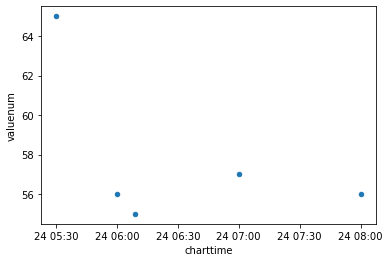

In [11]:
(
    chartevents_df.query("stay_id == 30600691 and itemid == 220045").
        plot.scatter(x="charttime", y="valuenum")
)

Note: as `print()` is not a method of `DataFrame`, we cannot chain print as what we did in R. There are tries to implement pipe using the bitwise or (`|`) operator, but I would not show it here. 

## Target cohort (from R section)

We aim to develop a predictive model, which computes the chance of dying within 30 days of ICU stay `intime` based on baseline features  
- `first_careunit`  
- `age` at `intime`  
- `gender`  
- `ethnicity`  
- first measurement of the following vitals since ICU stay `intime`  
    - 220045 for heart rate  
    - 220181 for Non Invasive Blood Pressure mean  
    - 220179 for Non Invasive Blood Pressure systolic  
    - 223761 for Temperature Fahrenheit  
    - 220210 for Respiratory Rate  

We restrict to the first ICU stays of each unique patient. 

## Wrangling and merging tibbles (from R section)

Our stragegy is

1. Identify and keep the first ICU stay of each patient. 

2. Identify and keep the first vital measurements during the first ICU stay of each patient.

3. Join four tibbles into a single tibble.

Important data wrangling concepts: group_by, sort, slice, joins, and pivot.

### Step 1: restrict to the first ICU stay of each patient

`icustays_df` has 76,540 rows, which is reduced to 53,150 unique ICU stays.

In [12]:
icustays_df_1ststay = icustays_df.sort_values(["subject_id", "intime"]).groupby("subject_id").first()

In [13]:
print(icustays_df_1ststay)

             hadm_id   stay_id  \
subject_id                       
10000032    29079034  39553978   
10000980    26913865  39765666   
10001217    24597018  37067082   
10001725    25563031  31205490   
10001884    26184834  37510196   
...              ...       ...   
19999442    26785317  32336619   
19999625    25304202  31070865   
19999828    25744818  36075953   
19999840    21033226  38978960   
19999987    23865745  36195440   

                                              first_careunit  \
subject_id                                                     
10000032                  Medical Intensive Care Unit (MICU)   
10000980                  Medical Intensive Care Unit (MICU)   
10001217                 Surgical Intensive Care Unit (SICU)   
10001725    Medical/Surgical Intensive Care Unit (MICU/SICU)   
10001884                  Medical Intensive Care Unit (MICU)   
...                                                      ...   
19999442                 Surgical Intensive C

In [14]:
icustays_df_1ststay = (icustays_df.sort_values(["subject_id", "intime"]).
                       groupby("subject_id").head(1)) # head() is much faster than slice_head(n) in dplyr
print(icustays_df_1ststay)

       subject_id   hadm_id   stay_id  \
66220    10000032  29079034  39553978   
57004    10000980  26913865  39765666   
25744    10001217  24597018  37067082   
10776    10001725  25563031  31205490   
45299    10001884  26184834  37510196   
...           ...       ...       ...   
40352    19999442  26785317  32336619   
20152    19999625  25304202  31070865   
24802    19999828  25744818  36075953   
56278    19999840  21033226  38978960   
53712    19999987  23865745  36195440   

                                         first_careunit  \
66220                Medical Intensive Care Unit (MICU)   
57004                Medical Intensive Care Unit (MICU)   
25744               Surgical Intensive Care Unit (SICU)   
10776  Medical/Surgical Intensive Care Unit (MICU/SICU)   
45299                Medical Intensive Care Unit (MICU)   
...                                                 ...   
40352               Surgical Intensive Care Unit (SICU)   
20152  Medical/Surgical Intensive C

### Step 2: restrict to the first vital measurements during the ICU stay

Key data wrangling concepts: selecting columns, left_join, right_join, group_by, sort, pivot

In [15]:
chartevents_df_1ststay = (
    chartevents_df.
    merge(
        icustays_df_1ststay[["stay_id", "intime", "outtime"]],
        how = "right",
        on = "stay_id"). # 15738363 rows
    query("charttime >= intime and charttime <= outtime"). # 15700234 rows
    sort_values(["stay_id", "itemid", "charttime"]).
    groupby(["stay_id", "itemid"]).
    head(1). # 263332 rows
    drop(["charttime", "intime", "outtime"], axis="columns").
    astype({"itemid": str}). # change it to string for easier renaming
    pivot(index="stay_id", columns="itemid", values="valuenum").
    rename(columns={"220045.0": "heart_rate",
            "220179.0": "bp_mean",
            "220181.0": "bp_syst",
            "223761.0": "temp_f",
            "220210.0": "resp_rate"})
)

In [16]:
chartevents_df_1ststay

itemid,heart_rate,bp_mean,bp_syst,resp_rate,temp_f
stay_id,,,,,
30000153.0,104.0,113.0,84.0,18.0,99.1
30000646.0,100.0,107.0,75.0,28.0,98.8
30001148.0,80.0,102.0,62.0,7.0,95.6
30001336.0,65.0,110.0,65.0,30.0,98.5
30001396.0,86.0,169.0,115.0,19.0,98.8
...,...,...,...,...,...
39999286.0,125.0,130.0,71.0,17.0,98.9
39999384.0,77.0,156.0,81.0,17.0,98.2
39999552.0,66.0,106.0,70.0,14.0,98.2


### Step 3: merge DataFrames

New data wrangling concept: mutate. Pandas equivalent is `assign`. 

In [17]:
mimic_icu_cohort = (
    icustays_df_1ststay.
    # merge dataframes
    merge(admissions_df, on=["subject_id", "hadm_id"], how="left").
    merge(patients_df, on=["subject_id"], how="left").
    merge(chartevents_df_1ststay, on=["stay_id"], how="left").
    # age_intime is the age at the ICU stay intime
    assign(age_intime = lambda df: 
           df["anchor_age"] + df["intime"].map(lambda x : x.year) - df["anchor_year"]).
    # whether the patient died within 30 days of ICU stay intime
    assign(hadm_to_death = lambda df: 
           np.where(np.isnan(df["deathtime"]), 
                    np.inf, 
                    (df["deathtime"] - df["intime"]).dt.total_seconds())).
    assign(thirty_day_mort = lambda df: df["hadm_to_death"] <= 2592000)   
)

In [18]:
mimic_icu_cohort

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,anchor_year_group,dod,heart_rate,bp_mean,bp_syst,resp_rate,temp_f,age_intime,hadm_to_death,thirty_day_mort
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,2014 - 2016,NaN,91.0,84.0,56.0,24.0,98.7,52,inf,False
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,2189-06-27 07:38:00,2189-07-03 03:00:00,...,2008 - 2010,NaN,77.0,150.0,92.0,23.0,98.0,76,inf,False
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,2157-11-18 22:56:00,2157-11-25 18:00:00,...,2011 - 2013,NaN,86.0,151.0,104.0,18.0,98.5,55,inf,False
3,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,2110-04-11 15:08:00,2110-04-14 15:00:00,...,2011 - 2013,NaN,55.0,73.0,59.0,19.0,97.7,46,inf,False
4,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,...,2008 - 2010,2131-01-20,38.0,180.0,46.0,10.0,98.1,77,780895.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53145,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,...,2008 - 2010,NaN,88.0,150.0,103.0,15.0,98.3,43,inf,False
53146,19999625,25304202,31070865,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741,2139-10-10 18:06:00,2139-10-16 03:30:00,...,2008 - 2010,NaN,96.0,152.0,91.0,19.0,98.9,82,inf,False
53147,19999828,25744818,36075953,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-08 16:44:00,2149-01-18 17:00:00,...,2017 - 2019,NaN,104.0,113.0,96.0,16.0,98.7,48,inf,False
53148,19999840,21033226,38978960,Trauma SICU (TSICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,...,2008 - 2010,2164-09-17,100.0,114.0,76.0,16.0,99.3,58,447332.0,True
